# Planning in the single-tunnel environment with multiple moving obstacles

In [1]:
import sys
sys.path.append('../../')
from panav.env import NavigationEnv, box_2d_center,gate
from panav.viz import draw_env


import numpy as np
from matplotlib import pyplot as plt
from time import time
from tqdm import trange
import pickle as pkl

%load_ext autoreload
%autoreload 2

## Environment

In [2]:
start_box_side = np.array([1,1])
goal_box_side = np.array([1,1])

top, bottom = 6,-6
start_x_offset = 7
goal_x_offset = 9
N = 5
bloating_r = 0.5

start_locs = np.vstack([
[start_x_offset,0],
np.vstack([np.ones(N)*(-start_x_offset),np.linspace(top,bottom, N)]).T])

goal_locs = np.vstack([
[-goal_x_offset,0],
np.vstack([np.ones(N)*goal_x_offset,np.linspace(bottom,top, N)]).T])


starts = [box_2d_center(s,start_box_side) for s in start_locs]
goals = [box_2d_center(g,goal_box_side) for g in goal_locs]
limits = [(-10.0,10.0),(-10.0,10.0)]

obstacles = []

x_loc = 0
y_loc = 0
opening_width = 1.5
wall_thickness = 6


obstacles += gate(x_loc,y_loc,opening_width,limits[1],wall_thickness)

env = NavigationEnv(limits,obstacles,starts[0:1],goals[0:1])

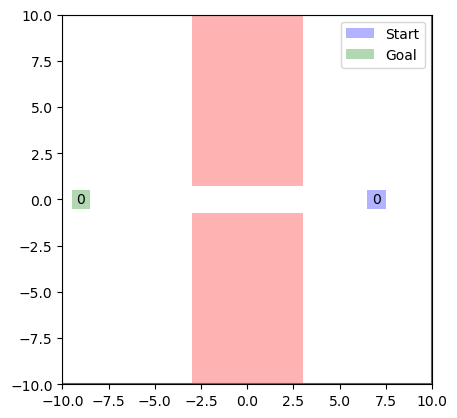

In [3]:
ax = plt.gca()
draw_env(env,show_agent_ID=True)
plt.show()    

# Generate obstacle trajectories (through planning)

In [4]:
from panav.SAMP import Tube_Planning
from panav.util import unique_tx
moving_obstacles = np.arange(len(starts)-1,0,-1)

obs_trajectory = []
for obs in moving_obstacles:
    print(obs)
    
    start = starts[obs]
    goal = goals[obs]

    vmax = 1.0
    space_dim = 2
    K = 6
    results = Tube_Planning(env,start,goal,vmax,bloating_r,\
                                obs_trajectory,\
                                space_dim,K,ignore_finished_agents=False)
    t,xs = results
    t,xs = unique_tx(t,xs)
    obs_trajectory.append((t,xs))






5
Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-15
4
3
2
1


# Plan for the true agent

In [63]:
start = env.starts[0]
goal = env.goals[0]

vmax = 1.0
space_dim = 2
times = []
solutions = []

Ks = trange(4,11)

for K in Ks:
    # print("K",K)
    t0 = time()

    results = Tube_Planning(env,start,goal,vmax,bloating_r,\
                                obs_trajectory,\
                                space_dim,K)
    times.append(time()-t0)

    
    solutions.append(results)
    # print(times)
    # t,xs = unique_tx(t,xs)
    # print(t)

100%|██████████| 7/7 [10:14<00:00, 87.79s/it] 


In [61]:
solutions

[None,
 (array([-0.     , 14.64214, 23.99791, 29.07086, 46.04143]),
  array([[ 6.5    ,  5.85215,  3.5    ,  3.5    , -8.5    ],
         [-0.5    , -2.75882, -3.83712, -0.25   , -0.25   ]]))]

In [64]:

data = {'Ks':list(Ks),'times':times,'solutions':solutions}
with open('data_singleTunnel.pkl','wb') as fp:
    pkl.dump(data,fp)

In [6]:
with open('data_singleTunnel.pkl','rb') as fp:
    data = pkl.load(fp)

Ks = data['Ks']
times = data['times']
solutions = data['solutions']

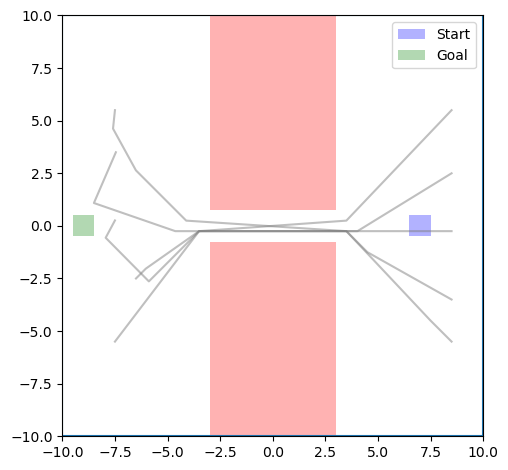

In [8]:
X = [xs for t,xs in obs_trajectory]
ax = plt.gca()
draw_env(env,X,ax,path_color='grey')
plt.tight_layout()
plt.savefig('./figures/singleTunnel_env.png')

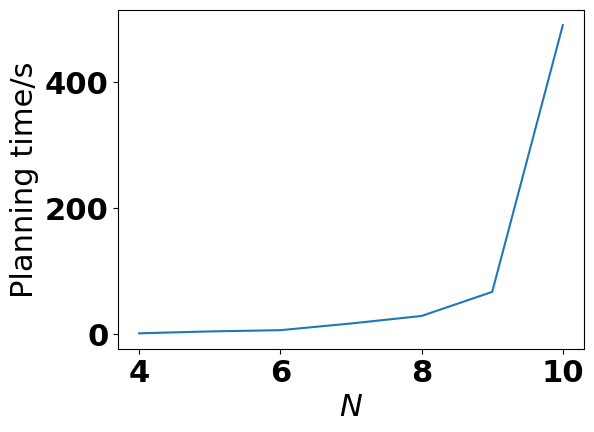

In [74]:
font = {'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)
plt.plot(list(Ks),times)
plt.xlabel(r'$N$')
plt.ylabel('Planning time/s')
plt.tight_layout()
plt.savefig('./figures/singleTunnel_planning_time.png')

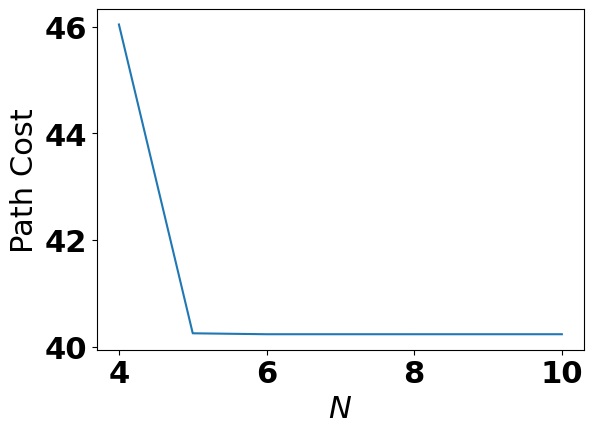

In [75]:
font = {'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)
plt.plot(list(Ks),[ts[-1] for ts,xs in solutions])
plt.xlabel(r'$N$')
plt.ylabel('Path Cost')
plt.tight_layout()
plt.savefig('./figures/singleTunnel_path_cost.png')

46.04142550499621 1.3363690376281738
40.24889677464541 4.34433388710022
40.23126395888055 6.308828830718994
40.23126395888054 16.91800594329834
40.2312334327375 28.850109100341797
40.231265080452964 67.03125190734863
40.23126508045297 489.71221709251404


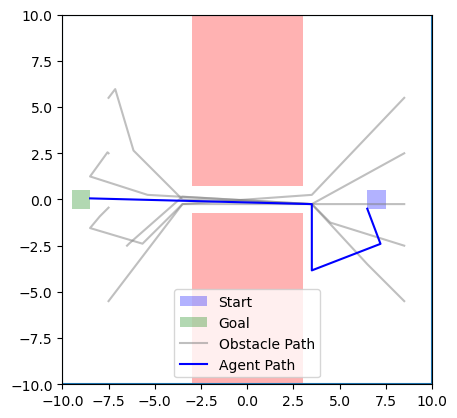

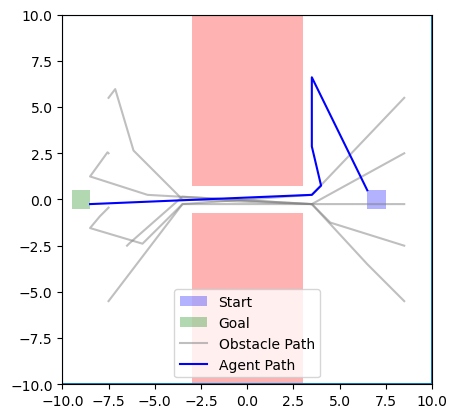

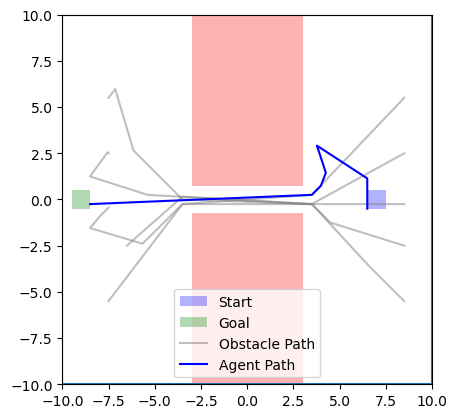

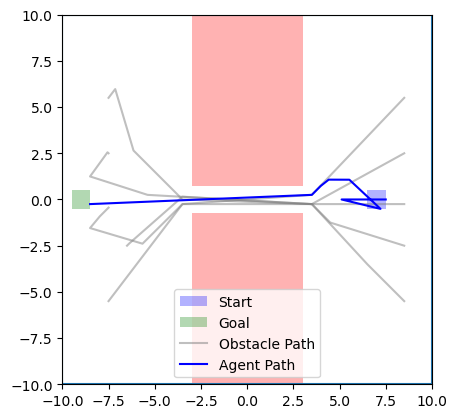

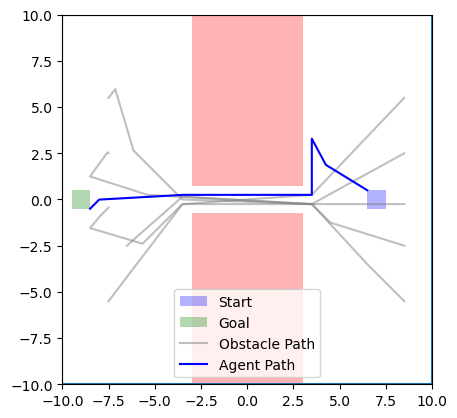

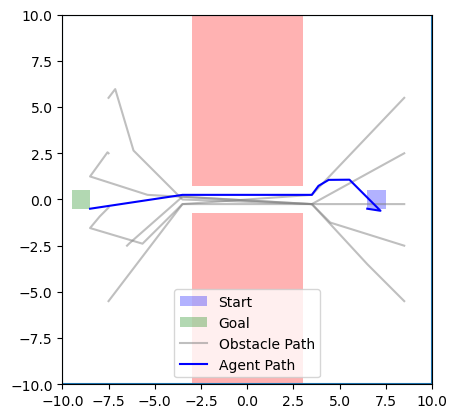

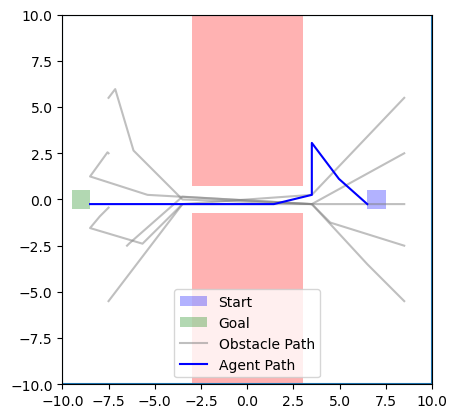

In [70]:

for k in range(len(solutions)):
    print(solutions[k][0][-1],times[k])
    X = [xs for t,xs in obs_trajectory]

    plt.figure()
    ax = plt.gca()
    draw_env(env,[],ax,path_color='grey')

    for i in range(len(X)):
        ax.plot(X[i][0,:],X[i][1,:],color = 'grey',alpha=0.5,label = 'Obstacle Path' if i==0 else None)

    xs = solutions[k][1]
    ax.plot(xs[0,:],xs[1,:],color = 'blue',label = 'Agent Path')
    ax.legend()
    plt.savefig('./figures/singleTunnelPlan_N{}.png'.format(Ks[k]))